# Make an Imbalanced Multi-class Classification Task

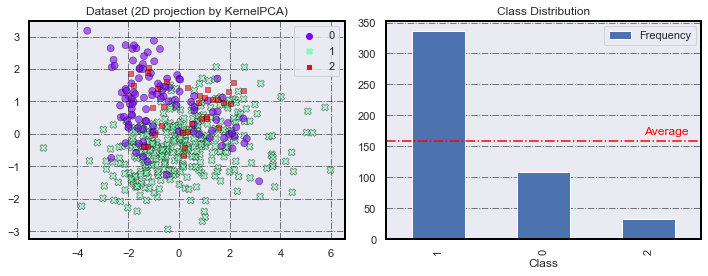

In [1]:
from duplebalance import DupleBalanceClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.decomposition import KernelPCA

import seaborn as sns
sns.set_theme(style="dark")

from utils import *
from plot import *

X, y = make_classification(n_samples=1000, n_features=4,  
                           n_classes=3, class_sep=0.8,
                           n_informative=3, n_redundant=1,
                           random_state=0, shuffle=False)
X, y = make_long_tail(X, y, imb_type='log', log_n=2, imb_ratio=10, random_state=42)

projection = KernelPCA(n_components=2).fit(X, y)
fig = plot_2Dprojection_and_cardinality(X, y, projection=projection)
plt.savefig("figures/dataset.png", dpi=150, bbox_inches='tight')
plt.show()

# An Example of Using DupleBalanceClassifier

In [2]:
X_train, X_test, y_train, y_test = imbalance_train_test_split(X, y, test_size=0.5, random_state=0)
base_estimator = DecisionTreeClassifier()
n_estimators = 10

clf = DupleBalanceClassifier(
    base_estimator=base_estimator,
    n_estimators=n_estimators, 
    verbose=1)
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)
score = macro_auc_roc_score(y_test, y_pred_proba)
print (f'\nMacro AUROC score: {score}\n')

----------------------------------------------------
# Samples     : 238
# Features    : [0 1 2 3]
# Classes     : 3
Classes       : 1/0/2
Class Dist    : 168/54/16
McIR          : 10.50/3.38/1.00
----------------------------------------------------
Iteration 1   : training set class distribution {0: 56, 1: 159, 2: 22}
Iteration 2   : training set class distribution {0: 59, 1: 150, 2: 29}
Iteration 3   : training set class distribution {0: 62, 1: 141, 2: 35}
Iteration 4   : training set class distribution {0: 64, 1: 132, 2: 41}
Iteration 5   : training set class distribution {0: 66, 1: 124, 2: 48}
Iteration 6   : training set class distribution {0: 69, 1: 115, 2: 54}
Iteration 7   : training set class distribution {0: 72, 1: 106, 2: 60}
Iteration 8   : training set class distribution {0: 74, 1: 97, 2: 66}
Iteration 9   : training set class distribution {0: 76, 1: 88, 2: 73}
Iteration 10  : training set class distribution {0: 79, 1: 79, 2: 79}

Macro AUROC score: 0.8575637816855138



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


# Compare DupleBalance with Other Baseline Methods

In [3]:
from tqdm import tqdm
import smote_variants as sv
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
import logging
logging.disable()

def imbStratifiedKFold(X, y, n_splits, shuffle=True, random_state=None):
    """StratifiedKFold for class-imbalanced dataset."""
    classes = np.unique(y)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    res = [([], [], [], []) for i_sp in range(n_splits)]
    for label in classes:
        label_ind = (y==label)
        X_label, y_label = X[label_ind], y[label_ind]
        split = 0
        for train_ind, test_ind in skf.split(X_label, y_label):
            res[split][0].append(X_label[train_ind])
            res[split][1].append(y_label[train_ind])
            res[split][2].append(X_label[test_ind])
            res[split][3].append(y_label[test_ind])
            split += 1
    res_split = [
        (
            np.concatenate(res[i][0]),
            np.concatenate(res[i][1]),
            np.concatenate(res[i][2]),
            np.concatenate(res[i][3]),
        ) for i in range(split)
    ]
    return res_split

def repeat_run(clf, X, y, sampler=None, method_name=None, 
               n_runs=5, n_splits=5, shuffle=True, random_state=None):
    """Obtain results from multiple independent run."""
    result_list = []
    for i_runs in tqdm(range(n_runs)):
        for X_train, y_train, X_test, y_test in imbStratifiedKFold(X, y, n_splits, shuffle, random_state):
            if sampler is None:
                X_train_res, y_train_res = X_train.copy(), y_train.copy()
            else:
                try:
                    X_train_res, y_train_res = sampler.sample(X_train, y_train)
                except Exception as e:
                    print (e)
            clf.fit(X_train_res, y_train_res)
            y_pred_proba = clf.predict_proba(X_test)
            score = macro_auc_roc_score(y_test, y_pred_proba)
            n_training_samples = X_train_res.shape[0] * clf.n_estimators
            result_list.append([score, method_name])

        df_result = pd.DataFrame(result_list, columns=['macro AUROC', 'Method'])
        df_result['# training samples'] = n_training_samples
    
    return df_result

repeat_run_params = {
    'X': X,
    'y': y,
    'n_runs': 5,
    'n_splits': 5,
    'shuffle': True,
    'random_state': 42,
}

sampler_dict = {
    'SMOTE': sv.MulticlassOversampling(sv.SMOTE(), strategy='equalize_1_vs_many'),
    'SMOTE_Tomek': sv.MulticlassOversampling(sv.SMOTE_TomekLinks(), strategy='equalize_1_vs_many'),
    'SMOTE_RSB': sv.MulticlassOversampling(sv.SMOTE_RSB(), strategy='equalize_1_vs_many'),
    'Gazzah': sv.MulticlassOversampling(sv.Gazzah(), strategy='equalize_1_vs_many'),
    'OUPS': sv.MulticlassOversampling(sv.OUPS(), strategy='equalize_1_vs_many'),
    'ANS': sv.MulticlassOversampling(sv.ANS(), strategy='equalize_1_vs_many'),
    'MDO': sv.MulticlassOversampling(sv.MDO(), strategy='equalize_1_vs_many'),
}

base_estimator = DecisionTreeClassifier()
n_estimators_list = [1, 5, 10, 20, 35, 50]
df_result_list = []

# run DupleBalance
print ('Running DupleBalance')
for n_estimators in n_estimators_list:
    repeat_run_params['sampler'] = None
    repeat_run_params['method_name'] = 'DupleBalance'
    repeat_run_params['clf'] = DupleBalanceClassifier(
        base_estimator=base_estimator,
        n_estimators=n_estimators,
        alpha=0.3,)
    df_result_list.append(repeat_run(**repeat_run_params))

# run Baselines
for sampler_name, sampler in sampler_dict.items():
    print (f'Running sampler {sampler_name}')
    repeat_run_params['sampler'] = sampler
    repeat_run_params['method_name'] = sampler_name
    for n_estimators in n_estimators_list:
        repeat_run_params['clf'] = BaggingClassifier(
            base_estimator=base_estimator,
            n_estimators=n_estimators)
        df_result_list.append(repeat_run(**repeat_run_params))

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Running DupleBalance


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.11it/s]

Running sampler SMOTE



 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00, 16.39it/s]

Running sampler SMOTE_Tomek


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  6.35it/s]

Running sampler SMOTE_RSB


 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00, 19.86it/s]

Running sampler Gazzah


 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00, 16.04it/s]

Running sampler OUPS


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Running sampler ANS


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  7.40it/s]

Running sampler MDO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.67it/s]


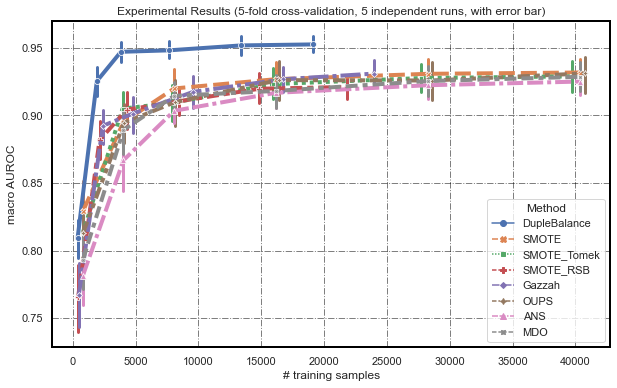

In [4]:
df_result_all = pd.concat(df_result_list)

line_width = 4
err_width = 3

fig = plt.figure(figsize=(10,6))
sns.set_theme(style="white")
ax = sns.lineplot(
    data=df_result_all, 
    x='# training samples', y='macro AUROC', hue='Method', style='Method', 
    markers=True, err_style='bars', linewidth=line_width)
ax = set_ax_border(ax, border_color='black', border_width=2)
ax.grid(color='black', linestyle='-.', alpha=0.5)
ax.set_title('Experimental Results ({}-fold cross-validation, {} independent runs, with error bar)'.format(
    repeat_run_params['n_splits'], repeat_run_params['n_runs']))

for child in ax.get_children():
    if str(type(child)).split('.')[-1][:-2] == 'LineCollection':
        child.set_linewidths(err_width)

plt.savefig("figures/results.png", dpi=150, bbox_inches='tight')

# Visualize Baseline Sampling Strategies

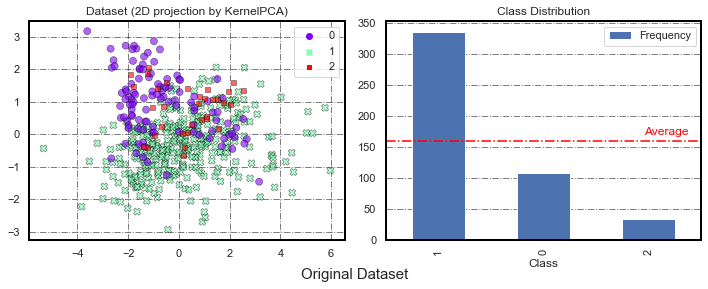

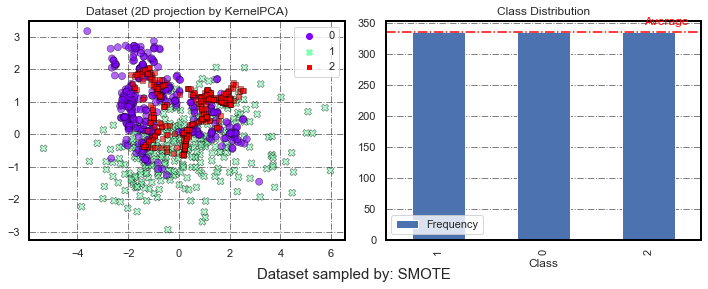

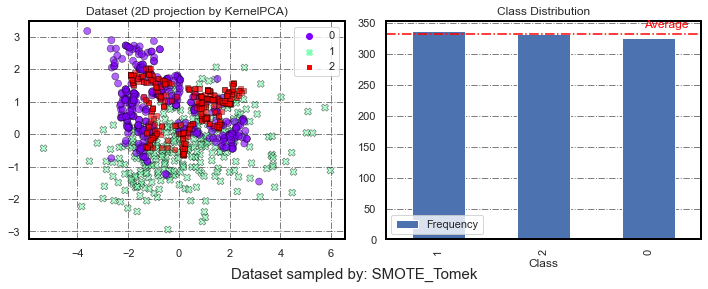

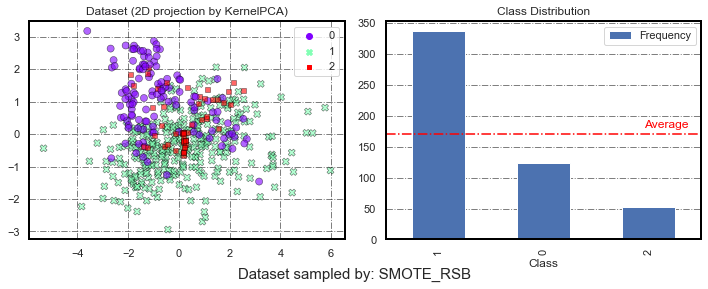

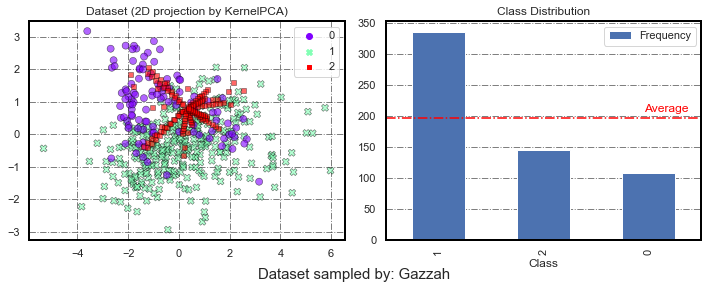

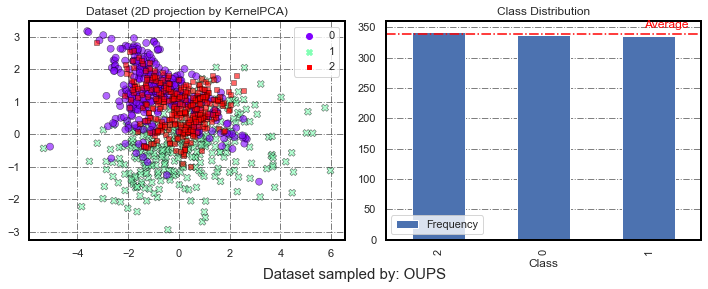

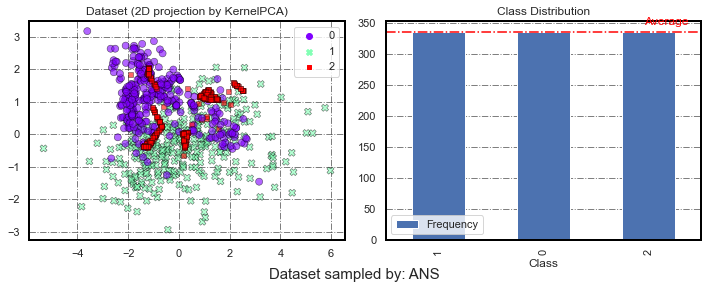

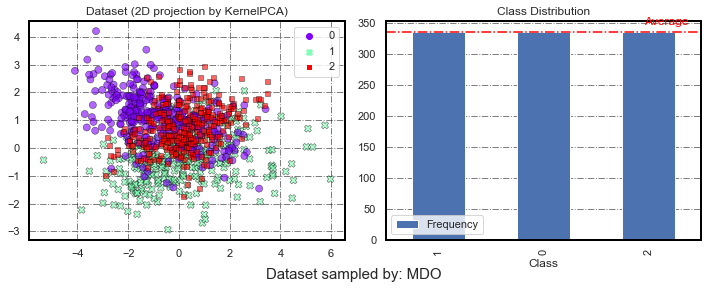

In [5]:
fig = plot_2Dprojection_and_cardinality(X, y, projection=projection)
fig.suptitle('Original Dataset', fontsize=15, y=0.05)

for sampler_name, sampler in sampler_dict.items():
    
    X_res, y_res = sampler.sample(X.copy(), y.copy())
    fig = plot_2Dprojection_and_cardinality(X_res, y_res, figsize=(10, 4), 
                                      projection=projection)
    fig.suptitle(f'Dataset sampled by: {sampler_name}', fontsize=15, y=0.05)
    plt.savefig(f"figures/dataset_{sampler_name}.png", dpi=150, bbox_inches='tight')
    plt.show()